In [1]:
!pip install --upgrade tensorflow
!pip install keras==3.3.3
import keras
print("Keras version:", keras.__version__)
import tensorflow as tf; print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:

from google.colab import drive
import os
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

# Mount Google Drive
drive.mount("/content/drive/")

# Define base directories
base_dir = "/content/drive/MyDrive/dataset/"
dataset_dir = os.path.join(base_dir, 'dataset')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

# Define source directories
cataract_dir = os.path.join(dataset_dir, 'cataract')
retinopathy_dir = os.path.join(dataset_dir, 'retinopathy')
glaucoma_dir = os.path.join(dataset_dir, 'glaucoma')
normal_dir = os.path.join(dataset_dir, 'normal')

# Function to split data into training and validation sets
def train_val_split(source, train, val, train_ratio):
    total_size = len(os.listdir(source))
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    randomized = random.sample(os.listdir(source), total_size)
    train_files = randomized[0:train_size]
    val_files = randomized[train_size:total_size]

    if not os.path.isdir(train):
        os.makedirs(train)
    if not os.path.isdir(val):
        os.makedirs(val)

    for i in train_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(train, i)
        copyfile(i_file, destination)

    for i in val_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(val, i)
        copyfile(i_file, destination)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 4

# Define directory paths
TRAIN_DIR = os.path.join(base_dir, "latih")
VALIDATION_DIR = os.path.join(base_dir, "validasi")

# Define data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['cataract', 'retinopathy', 'glaucoma', 'normal']
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['cataract', 'retinopathy', 'glaucoma', 'normal']
)


Found 3792 images belonging to 4 classes.
Found 661 images belonging to 4 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
# Define model architecture
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
x_mobilenet = base_model_mobilenet.output
x_mobilenet = GlobalAveragePooling2D()(x_mobilenet)
x_mobilenet = Dense(256, activation='relu')(x_mobilenet)
predictions = Dense(NUM_CLASSES, activation='softmax')(x_mobilenet)

model = Model(inputs=base_model_mobilenet.input, outputs=predictions)

# Freeze layers
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


def custom_data_generator(generator):
    while True:
        try:
            X, y = next(generator)
            yield X, y
        except (FileNotFoundError, IsADirectoryError, UnidentifiedImageError, Image.UnidentifiedImageError):
            continue

# Train model
history = model.fit(
    custom_data_generator(train_generator),
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=custom_data_generator(validation_generator),
    validation_steps=len(validation_generator),
)

# Save the final model
final_model_path = "/content/drive/MyDrive/mobile-netv2.h5"
model.save(final_model_path)

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 735s 6s/step - accuracy: 0.6417 - loss: 0.9201 - val_accuracy: 0.7519 - val_loss: 0.6306
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8140 - loss: 0.4962 - val_accuracy: 0.7519 - val_loss: 0.6394
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.8129 - loss: 0.4761 - val_accuracy: 0.7700 - val_loss: 0.6534
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8155 - loss: 0.4505 - val_accuracy: 0.8306 - val_loss: 0.4302
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8451 - loss: 0.4030 - val_accuracy: 0.8366 - val_loss: 0.4570
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8428 - loss: 0.3893 - val_accuracy: 0.8411 - val_loss: 0.4423
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.8563 - loss: 0.3636 - val_accuracy: 0.7716 - val_loss: 0.5948
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.8577 - loss: 0.3677 - 

In [5]:
# Save the final model
final_model_path = "/content/drive/MyDrive/mobile-netv2.h5"
model.save(final_model_path)

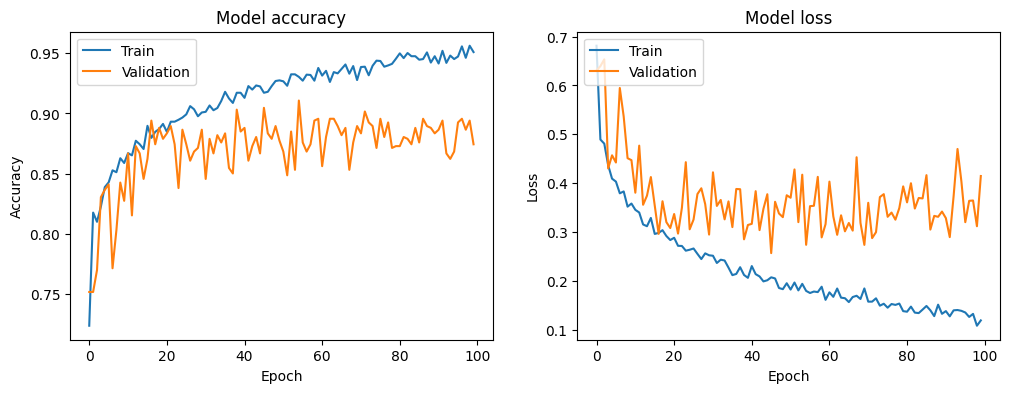

In [6]:
# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Upload an image for prediction
uploaded = files.upload()
for filename in uploaded.keys():
    img_path = filename
    img_array = load_and_preprocess_image(img_path, IMAGE_SIZE)

    # Make prediction
    prediction = model.predict([img_array, img_array])
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map predicted class index to class name
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    # Display the image and prediction
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# Function to plot the results
def plot_results(images, true_labels, predicted_labels, class_labels, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.tight_layout()
    plt.show()

# Function to evaluate and plot results for a batch of data
def evaluate_and_plot_results(generator, model, class_labels, num_images=10):
    images, true_labels = next(generator)
    predictions = model.predict([images, images])
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    # Convert class indices to class names
    class_labels = {v: k for k, v in class_labels.items()}

    # Plot results without normalizing images for display
    plot_results(images, true_labels, predicted_labels, class_labels, num_images=num_images)

# Evaluate and plot results for training data
evaluate_and_plot_results(train_generator, model, train_generator.class_indices, num_images=10)

# Evaluate and plot results for validation data
evaluate_and_plot_results(validation_generator, model, validation_generator.class_indices, num_images=10)